# Human PBMCs from Freytag et al.

Here we analyse the PBMCs from a healthy donor (v2 chemistry)(Cell Ranger 2.0.0) published by [Freytag et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)
Link to the dataset: [GSE115189](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse115189)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Freytag_pbmcs.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [37]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [5]:
# Set up data loading
file = '../../Munich/datasets/human/Freytag_PBMC/GSM3169075_filtered_gene_bc_matrices_h5.h5'
adata = sc.read_10x_h5(filename=file)

reading ../../Munich/datasets/human/Freytag_PBMC/GSM3169075_filtered_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


In [6]:
adata

AnnData object with n_obs × n_vars = 3372 × 58302 
    var: 'gene_ids'

In [7]:
adata.var.head()

,gene_ids
DDX11L1,ENSG00000223972
WASH7P,ENSG00000227232
MIR6859-1,ENSG00000278267
MIR1302-2HG,ENSG00000243485
MIR1302-2,ENSG00000284332


In [8]:
adata.X = adata.X.toarray()

In [9]:
adata.var_names_make_unique()

In [11]:
# Checking the total size of the data set
adata.shape

(3372, 58302)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [13]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


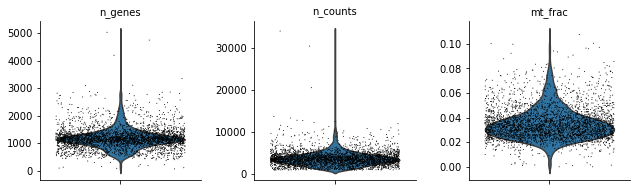

In [14]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

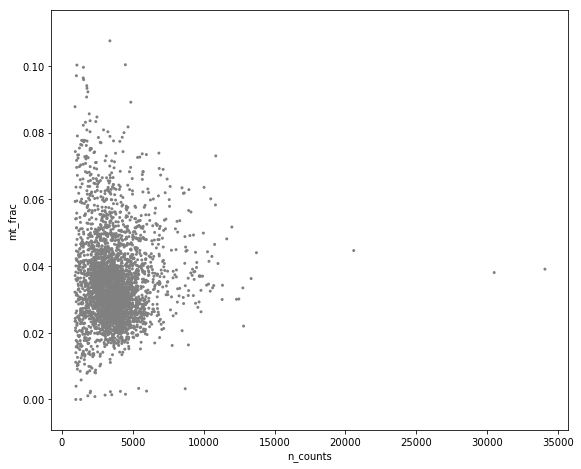

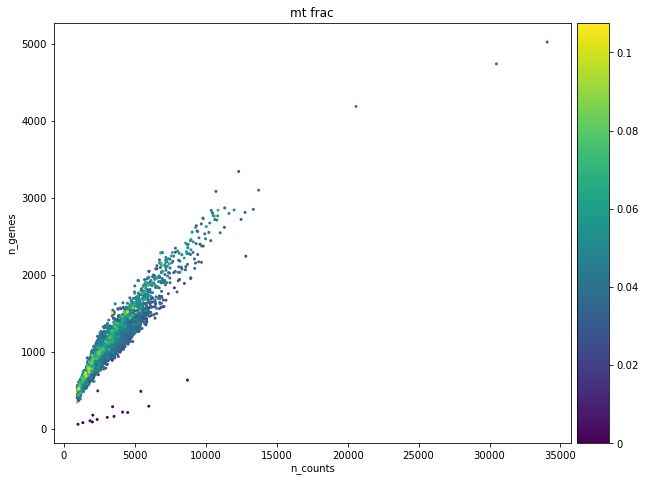

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


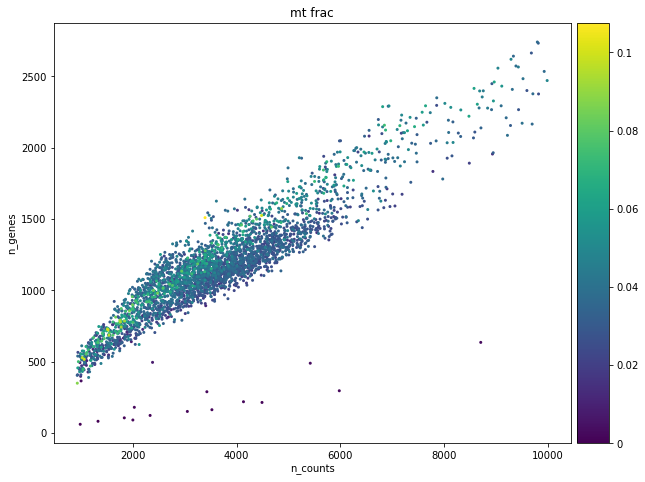

In [15]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='mt_frac')

There are a bunch of cells separating from the rest, with low number of genes and relatively high counts. We want to exclude them. Also, we exclude a couple of cells with very high n_genes and n_count, which could be doublets.

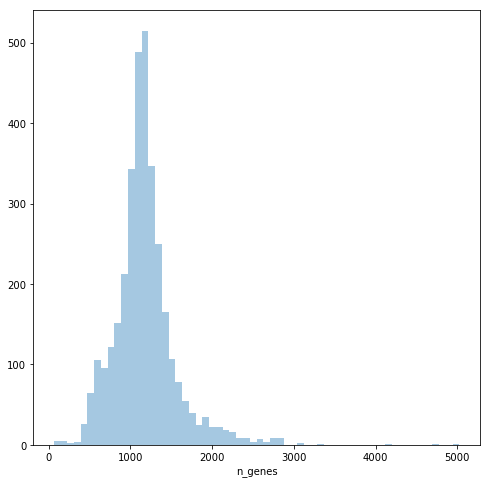

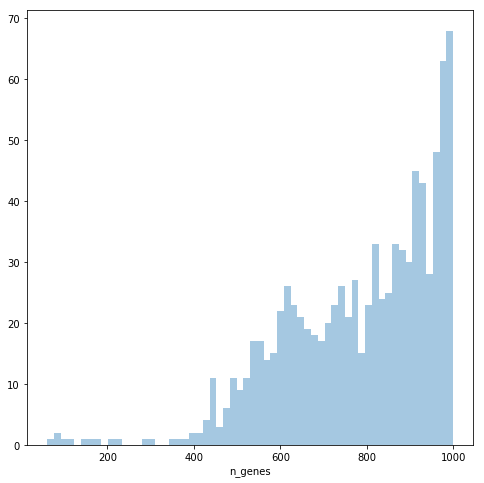

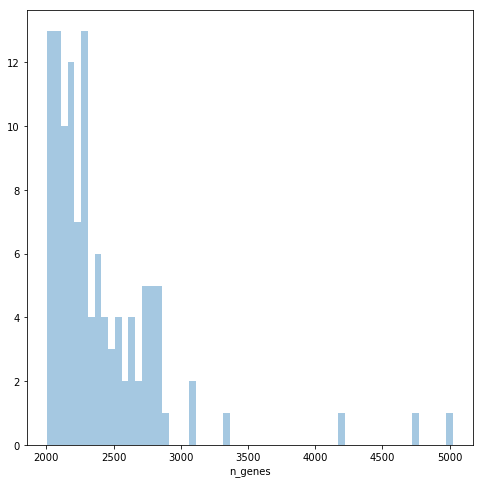

In [16]:
#Thresholding decision: genes
p1 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p2 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>2000], kde=False, bins=60)
plt.show()


In [17]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 3000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 3372
filtered out 16 cells that haveless than 400 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Number of cells after gene filter: 3356
filtered out 6 cells that havemore than 3000 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Number of cells after gene filter: 3350


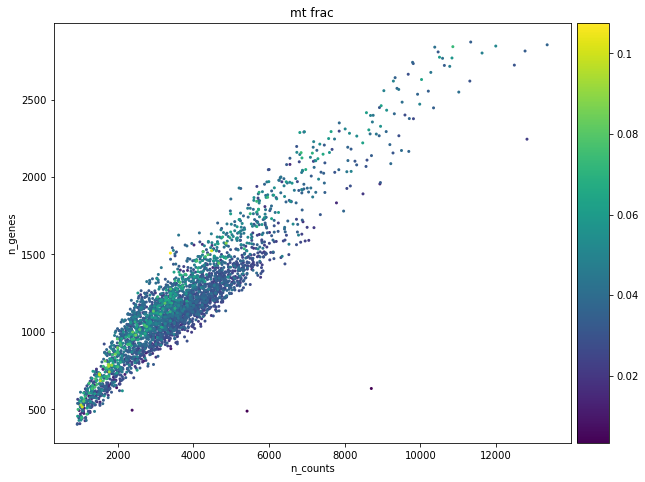

In [18]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


We still want to get rid of those 3 remaining cells which are clearly separating from the rest.

In [19]:
print('Total number of cells: {:d}'.format(adata.n_obs))
adata = adata[~((adata.obs['n_counts'] > 2000) & (adata.obs['n_genes'] < 500))]
print('Number of cells after filter: {:d}'.format(adata.n_obs))
adata = adata[~((adata.obs['n_counts'] > 8000) & (adata.obs['n_genes'] < 800))]
print('Number of cells after filter: {:d}'.format(adata.n_obs))

Total number of cells: 3350
Number of cells after filter: 3348
Number of cells after filter: 3347


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


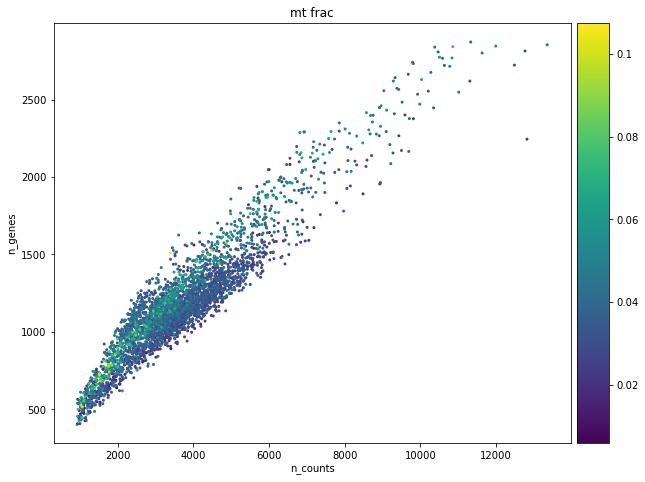

In [20]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

There's no need of further filtering on mitochondrial fraction or number of counts.

In [21]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58302
filtered out 45649 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12653


## 1.2 Normalization

In [22]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [23]:
# Check the number of cells per cluster
adata_pp.obs['groups'].value_counts()

0    725
1    640
2    489
3    424
4    372
5    362
6    319
7     16
Name: groups, dtype: int64

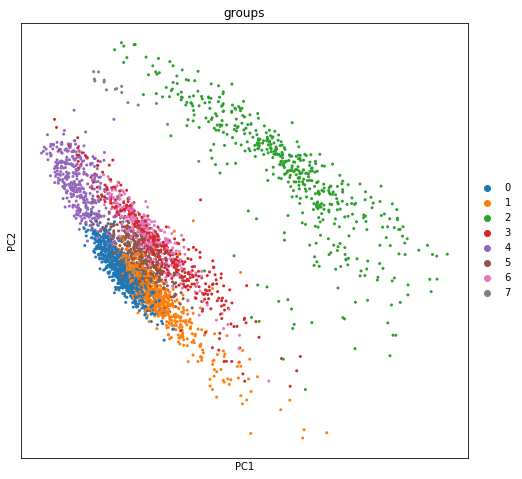

In [24]:
# Check that the smallest cluster (which is < 21) doesn't show any problem
sc.pl.pca_scatter(adata_pp, color='groups')

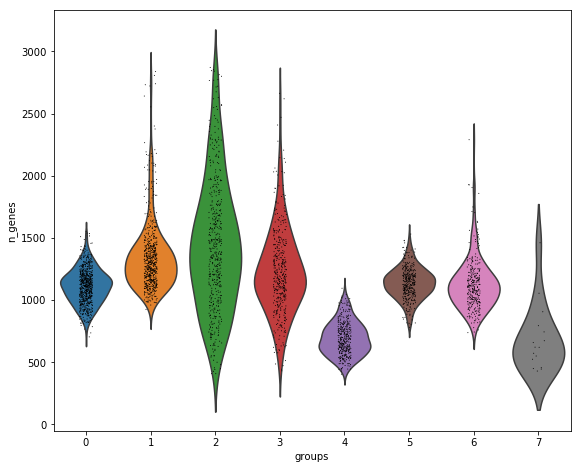

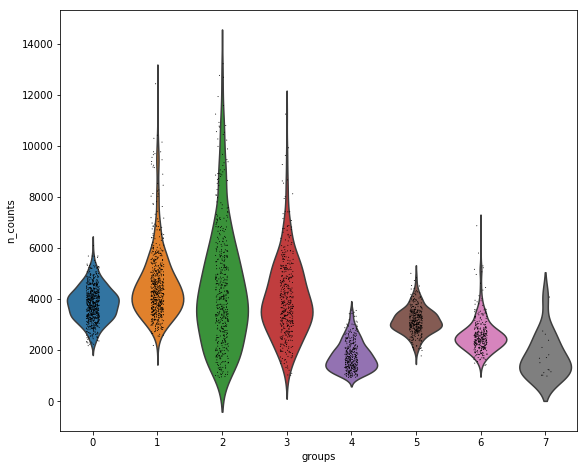

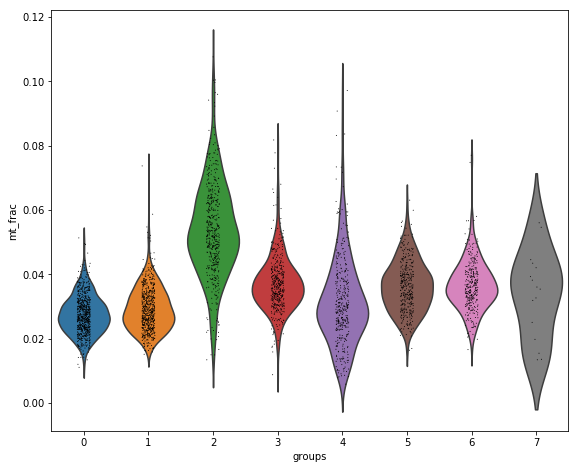

In [25]:
sc.pl.violin(adata_pp, 'n_genes', groupby= 'groups')
sc.pl.violin(adata_pp, 'n_counts', groupby= 'groups')
sc.pl.violin(adata_pp, 'mt_frac', groupby= 'groups')

In [26]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [27]:
# Having the smallest cluster size = 16 we need to pass sizes as input
sizes = input_groups.value_counts()

In [28]:
%%R -i data_mat -i input_groups -i sizes -o size_factors

size_factors = computeSumFactors(data_mat, sizes = sizes, clusters=input_groups, min.mean=0.1)

In [29]:
#Delete adata_pp
del adata_pp

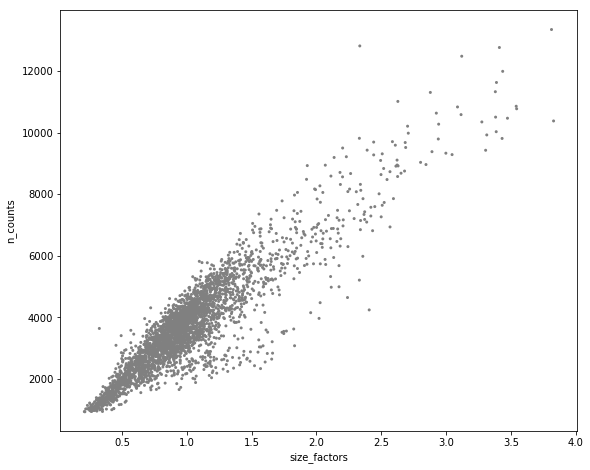

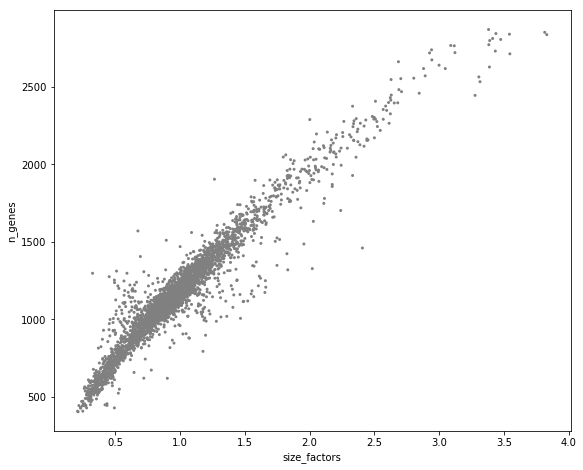

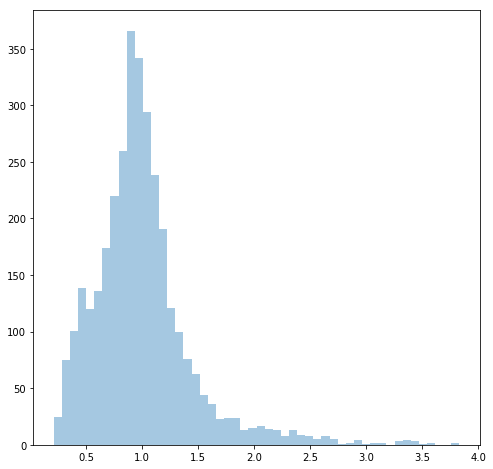

In [30]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [31]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [32]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [33]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [34]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


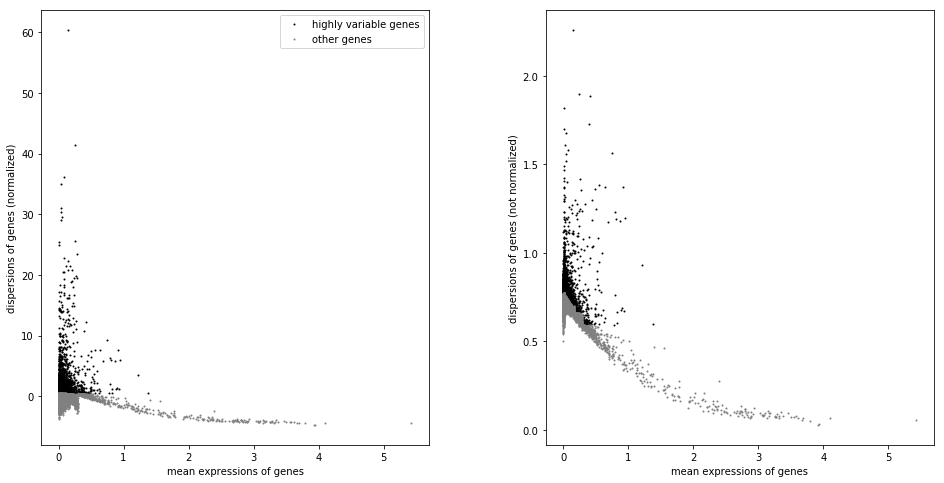

In [35]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [36]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP


/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.999855   0.99875176 0.996841   0.9899288
     0.98202944 0.9660006  0.95895565 0.9291915  0.9268565  0.92267364
     0.9113079  0.89836633 0.8858525 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:30)


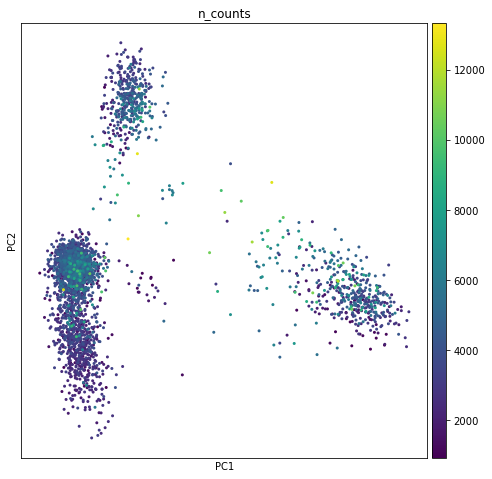

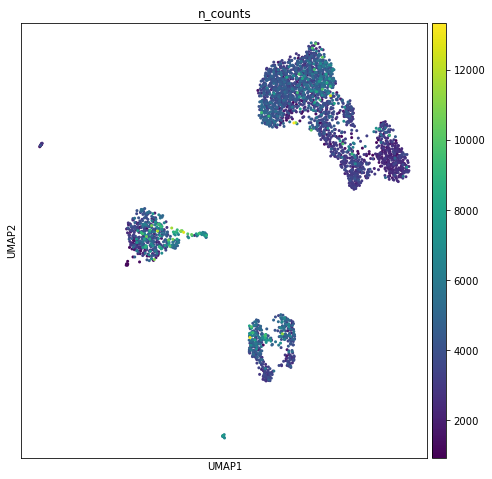

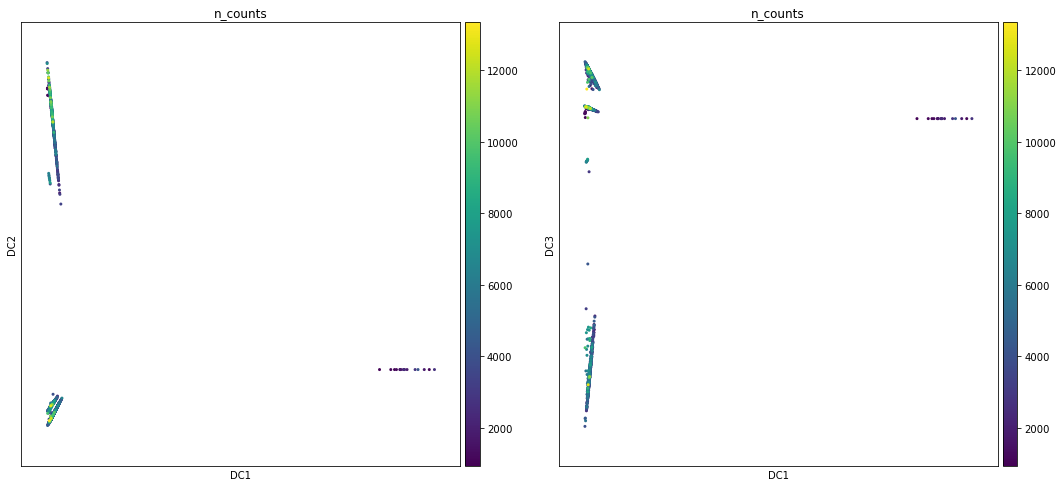

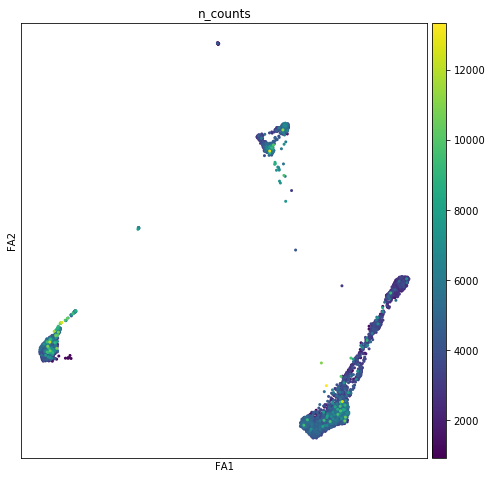

In [37]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [38]:
adata.write(results_file)

# 3. Clustering

In [39]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [40]:
adata.obs['louvain_r1'].value_counts()

0    774
1    734
2    452
3    373
4    284
5    272
6    251
7    166
8     25
9     16
Name: louvain_r1, dtype: int64

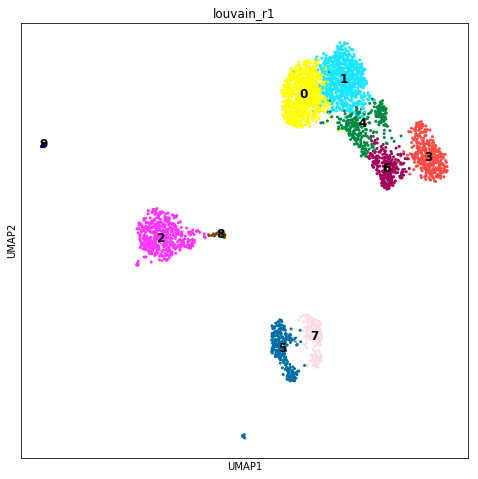

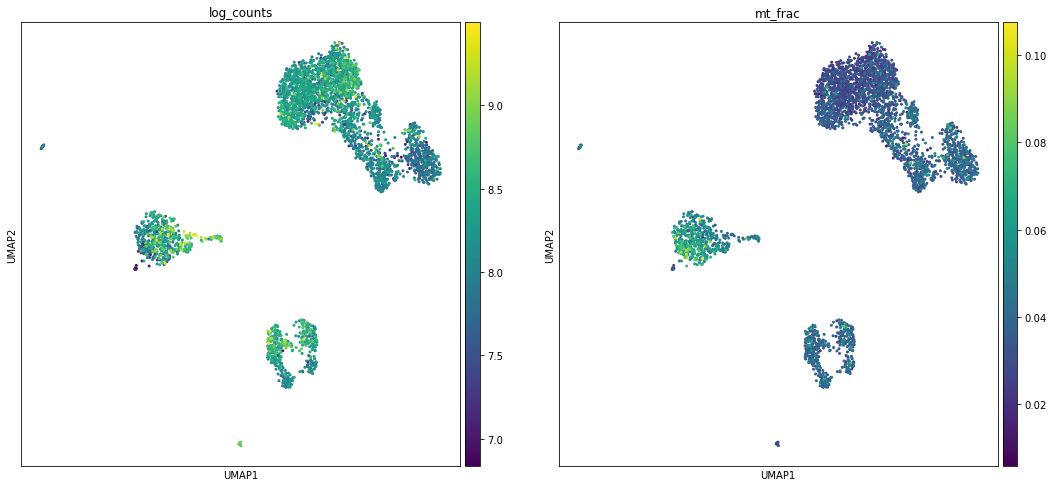

In [41]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

# 4. Marker genes and cluster annotation (r 1)

In [42]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [44]:
markers_df = pd.read_csv('../../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [45]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [46]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [47]:
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [48]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [49]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [50]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

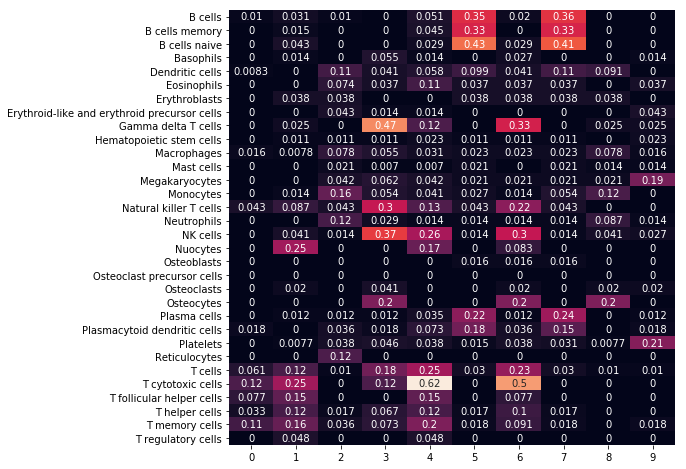

In [51]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [134]:
adata.write(results_file)

# 5. Plot makers of subtypes

In [52]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells
We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

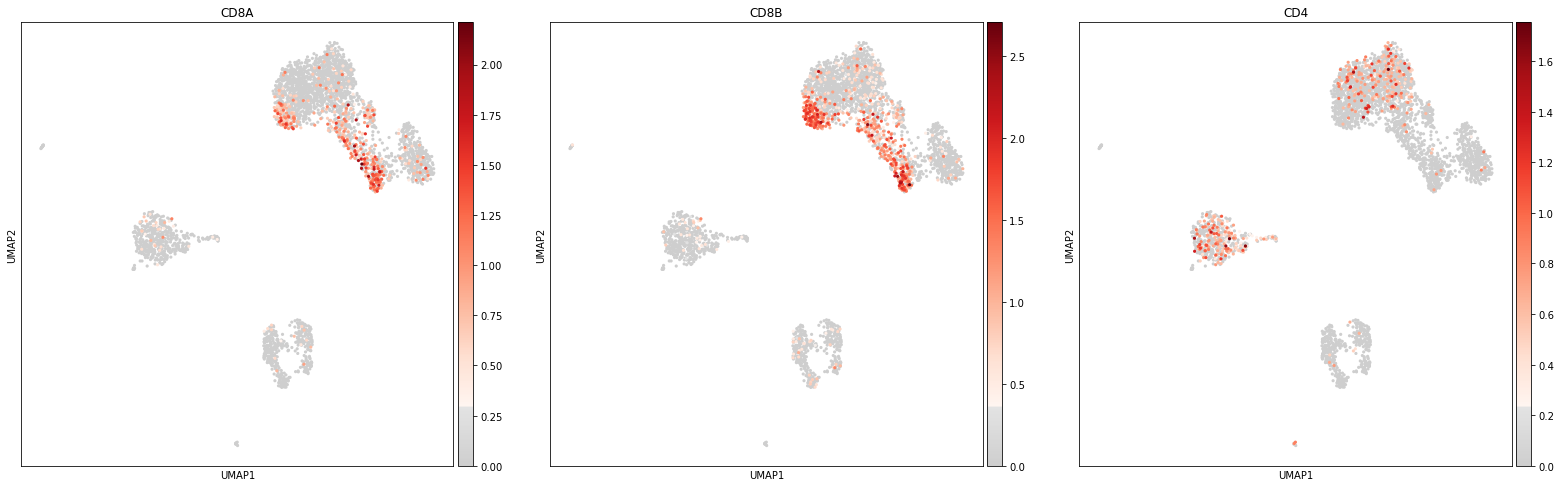

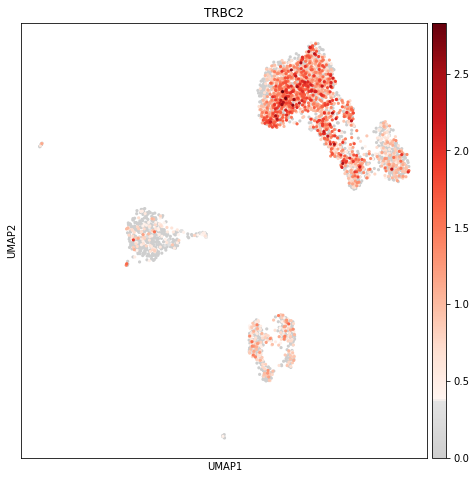

In [54]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 40)

# Markers from MCA
sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap, size = 40)

We need to subcluster cluster 0 and 4 to annotate CD8+ T cells.

### Natural killer T cells and NK cells
We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

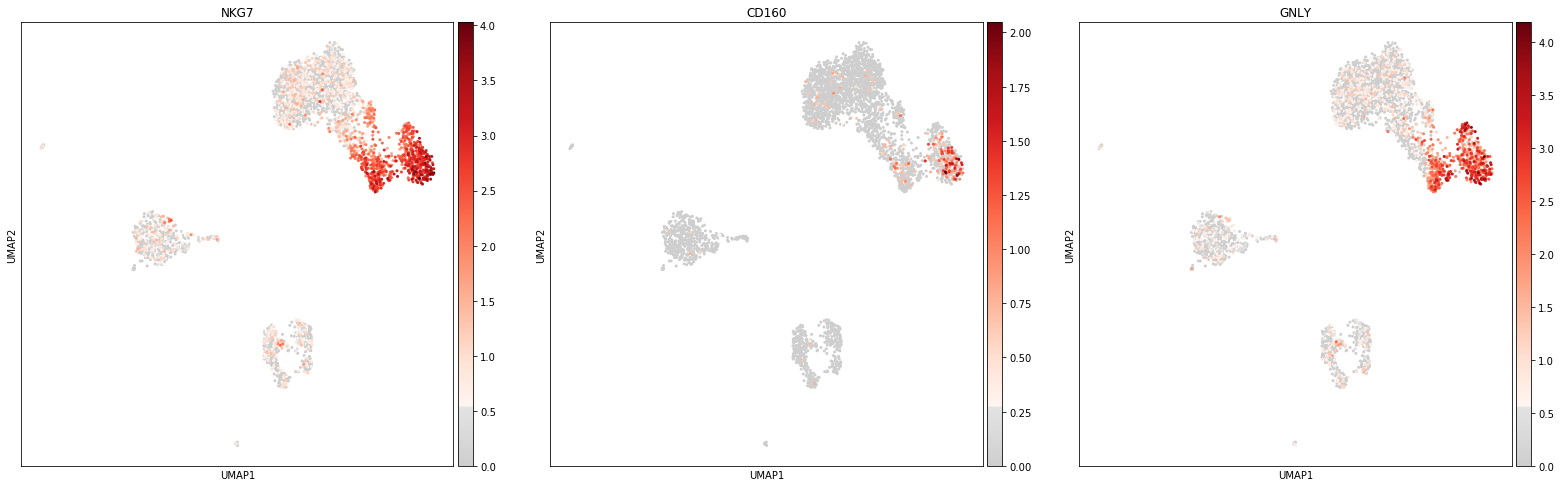

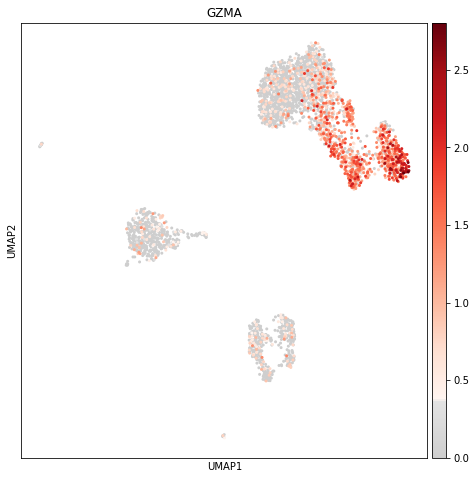

In [55]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

NKT cells in cluster 4 and 6, NK cells part of 4 and 3.

## Monocytes: CD14+ and CD16+

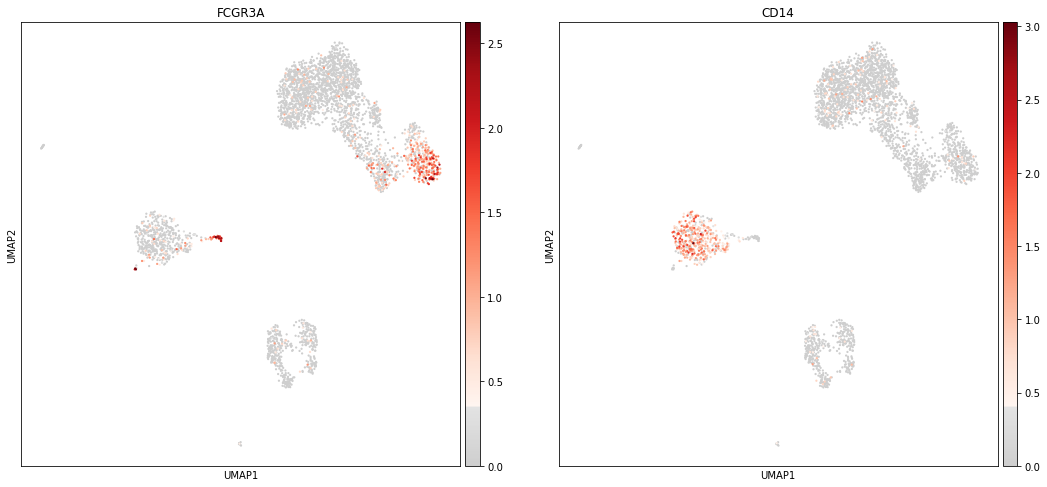

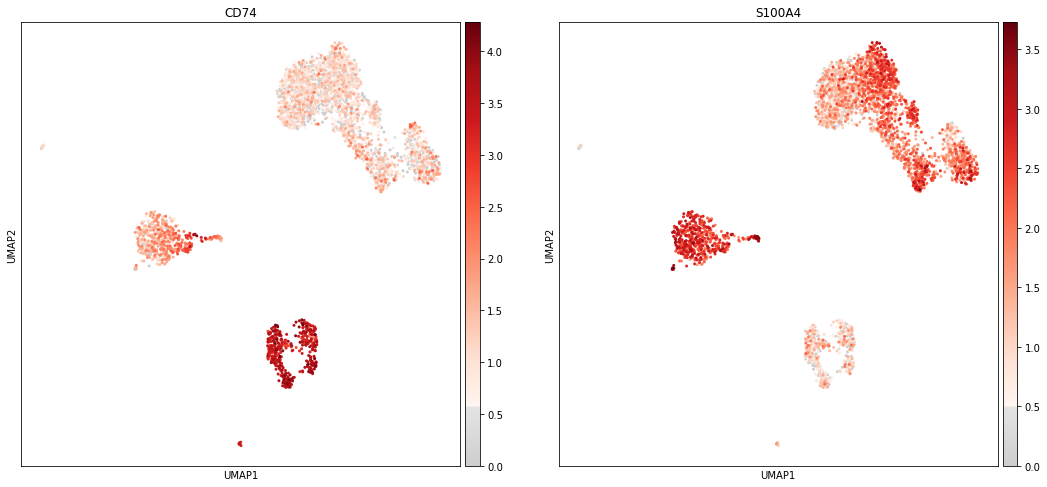

In [56]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap, size = 20)
# markers from MCA
sc.pl.umap(adata, color=['CD74', 'S100A4'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

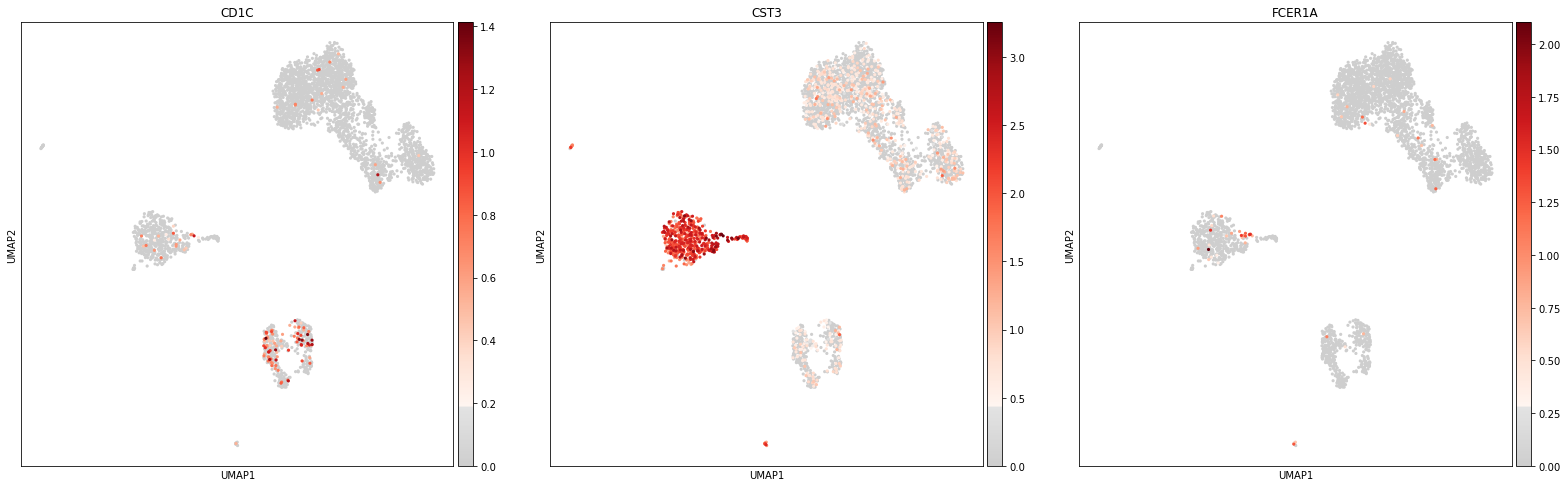

In [57]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap, size = 40)

Not significantly enriched.

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

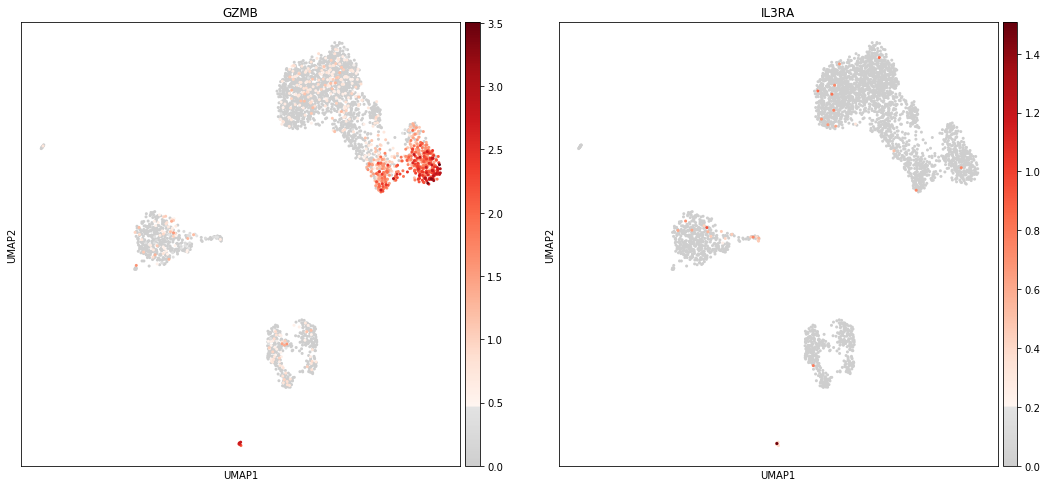

In [58]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

The very small cluster separating from cluster 5 (subclustering).

## B cells
Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).

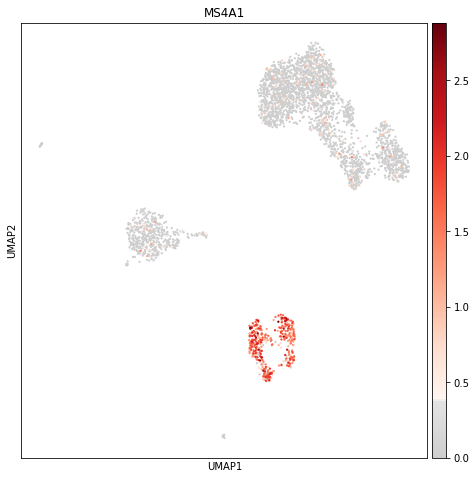

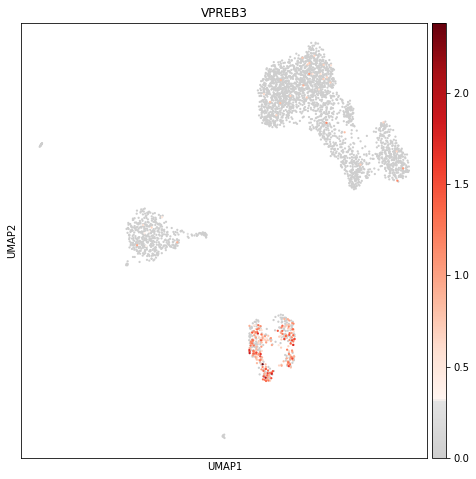

In [61]:
# MME not present
sc.pl.umap(adata, color=['MS4A1'], use_raw=False, color_map=mymap, size = 20)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3'], use_raw=False, color_map=mymap, size = 20)

## Megakaryocyte progenitors

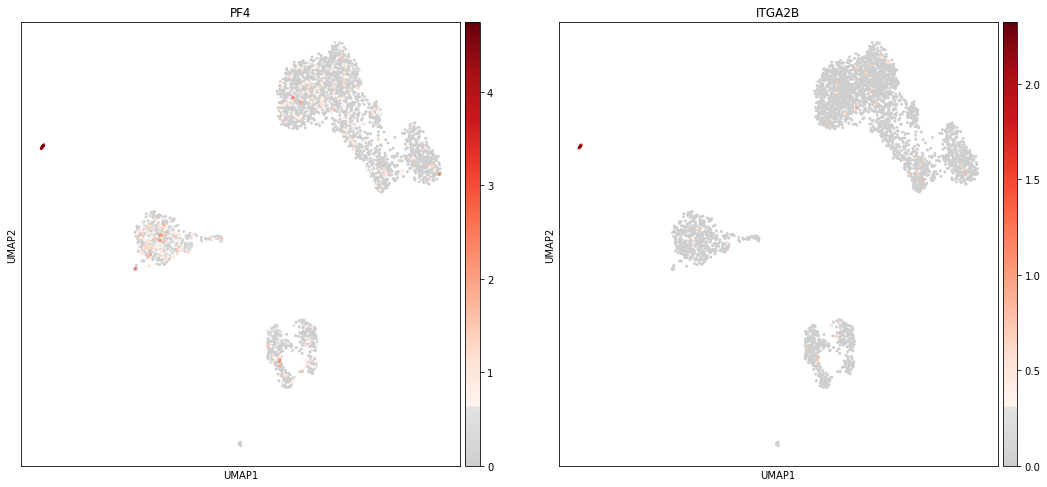

In [62]:
sc.pl.umap(adata, color=['PF4', 'ITGA2B'], use_raw=False, color_map=mymap)

# 6. Subclustering

We subcluster clusters 0, 4 and 5.

In [63]:
#Subcluster cluster0
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['0']), resolution=0.5, key_added='louvain1_sub_0')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain1_sub_0', the cluster labels (adata.obs, categorical) (0:00:00)


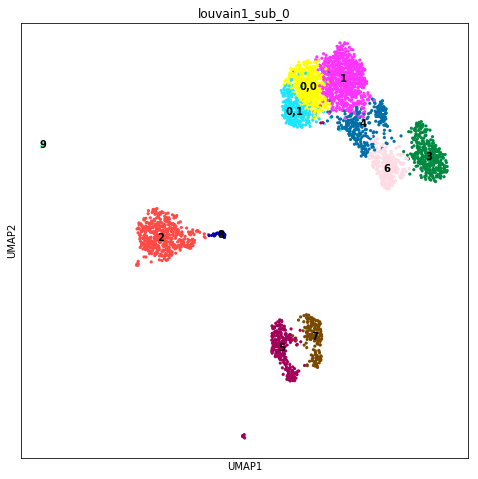

In [64]:
#Show the new clustering
sc.pl.umap(adata, color='louvain1_sub_0', size = 40, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [65]:
#Subcluster cluster2
sc.tl.louvain(adata, restrict_to=('louvain1_sub_0', ['4']), resolution=0.5, key_added='louvain1_sub_0_4')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain1_sub_0_4', the cluster labels (adata.obs, categorical) (0:00:00)


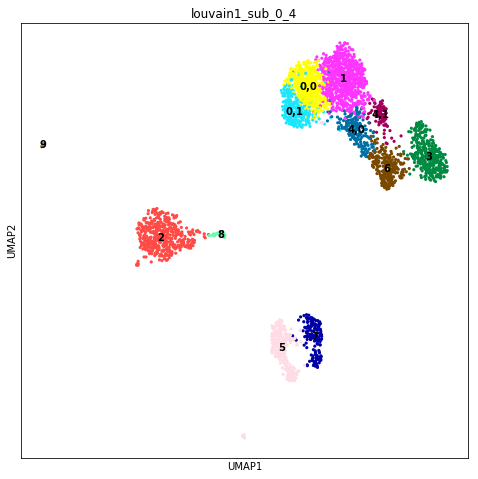

In [66]:
#Show the new clustering
sc.pl.umap(adata, color='louvain1_sub_0_4', size = 40, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [71]:
#Subcluster cluster5
sc.tl.louvain(adata, restrict_to=('louvain1_sub_0_4', ['5']), resolution=0.3, key_added='louvain1_sub_0_4_5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain1_sub_0_4_5', the cluster labels (adata.obs, categorical) (0:00:00)


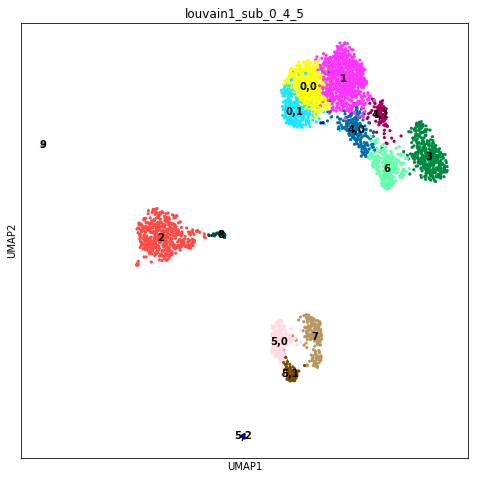

In [72]:
#Show the new clustering
sc.pl.umap(adata, color='louvain1_sub_0_4_5', size = 40, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

# 8. Final cell-type annotation

In [73]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain1_sub_0_4_5']
adata.rename_categories('final_annotation', ['CD4+ T cells,1',
                                             'CD8+ T cells', 
                                             'CD4+ T cells,2',
                                             'CD14+ Monocytes',
                                             'NK cells,1',
                                             'NKT cells,1',
                                             'NK cells,2',
                                             'CD20+ B cells,1',
                                             'CD20+ B cells,2',
                                             'Plasmacytoid dendritic cells',
                                             'NKT cells,2',
                                             'CD20+ B cells,3',
                                             'CD16+ Monocytes',
                                             'Megakaryocyte progenitors'])

In [75]:
tmp = adata.obs['final_annotation']
tmp = ['CD20+ B cells' if item.startswith('CD20+ B cells') else item for item in tmp]
tmp = ['CD4+ T cells' if item.startswith('CD4+ T ') else item for item in tmp]
tmp = ['NK cells' if item.startswith('NK cells') else item for item in tmp]
tmp = ['NKT cells' if item.startswith('NKT cells') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


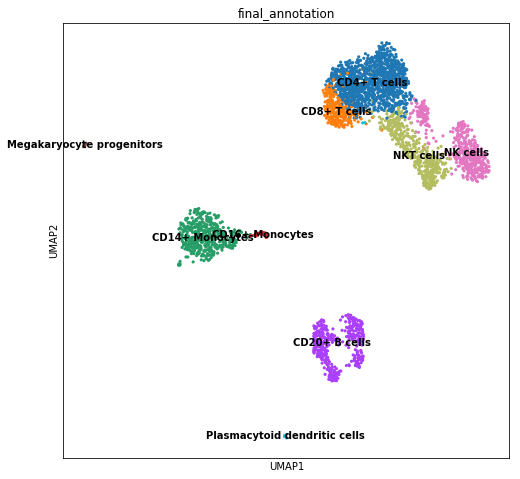

In [76]:
sc.pl.umap(adata, color='final_annotation', size=40, legend_loc='on data')

In [77]:
# save final result
adata.write(results_file)